In [1]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline

# jt -t monokai -N -T -kl -nfs 10 -tfs 10
from jupyterthemes import jtplot
jtplot.style(theme='monokai')

In [2]:
#Now we have to read those pianorolls and then transform them into images so that we can use a CNN on them
import pypianoroll as pypr

a = pypr.load('/home/marco/workspace/musical-genre-from-pianorolls/data/lpd_5/lpd_5_cleansed/A/A/L/TRAALAH128E078234A/8cfecf566c75342d13c327f8a7abc414.npz')
# pypr.plot(a)

In [3]:
a.get_stacked_pianoroll().shape # this is now a numpy array, so it's good!

(6552, 128, 5)

(128, 6552, 5)
127
0
[  0  68  69  78  80  86  89  92  93  96 100 101 105 109 110 115 116 121
 125 127]
uint8


255
0
[  0 136 138 156 160 172 178 184 186 192 200 202 210 218 220 230 232 242
 250 255]
uint8




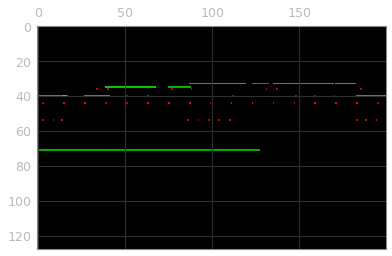

In [4]:
from matplotlib import pyplot
import numpy as np

img = np.transpose(a.get_stacked_pianoroll(),(1,0,2))

print(img.shape)

print(np.max(img))
print(np.min(img))
print(np.unique(img))
print(img.dtype)
print()
print()

img = (img-np.min(img))/(np.max(img)-np.min(img))*255

img = np.floor(img)
img = img.astype('uint8') 
print(np.max(img))
print(np.min(img))
print(np.unique(img))
print(img.dtype)
print()
print()

submat = img[:,5000:5200,:3] #  we can only display 3 channels images by default

pyplot.matshow(submat)

In [5]:
# pyplot.imsave('prova.png',img)
# this doesn't work though because we're trying to save an image with 5 channels. But do we need to save them as images? 
# No right? they could just as well be saved as 'simple' tensors...

In [6]:
import torch

In [7]:
t = torch.from_numpy(img)
torch.save(t,'tensor_0.pt')

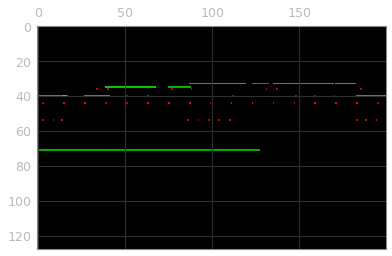

In [8]:
import os

os.listdir() # tensor_0 is there!

t2 = torch.load('tensor_0.pt')
subtens = t2[:,5000:5200,:3] #  we can only display 3 channels images by default
pyplot.matshow(subtens)

Ok so that works, I now need to:
  * figure out how to reduce space on disk, one tensor is 4.2 MB !! Can we save a sparse repr? Can we just cut unused pitches?
  * get them all
  * pad them to equal length
  * save them all
  * get the labels (maybe out a csv?)

In [9]:
# Can we save them as sparse tensors?
ts = t.to_sparse()

torch.save(ts.indices(),'tensor_0_indices.pt')
torch.save(ts.values(),'tensor_0_values.pt')
torch.save(ts.size(),'tensor_0_sizes.pt')

#### Now read it back
t_indices, t_values, t_sizes = torch.load('tensor_0_indices.pt'), torch.load('tensor_0_values.pt'), torch.load('tensor_0_sizes.pt')

# to get back use torch.sparse_coo_tensor(indices, values, sizes).to_dense()
t_reconstructed = torch.sparse_coo_tensor(t_indices, t_values, t_sizes).to_dense()
torch.all( t == t_reconstructed)

tensor(True)

We'll need to test how much slower loading this is though....let's see

In [10]:
def load_sparse_tensor(partial_file_name):
    t_indices = torch.load(partial_file_name+'_indices.pt')
    t_values = torch.load(partial_file_name+'_values.pt')
    t_sizes = torch.load(partial_file_name+'_sizes.pt')
    return torch.sparse_coo_tensor(t_indices, t_values, t_sizes).to_dense()

%timeit load_sparse_tensor('tensor_0')
%timeit torch.load('tensor_0.pt')

4.23 ms ± 349 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)
1.12 ms ± 94.5 µs per loop (mean ± std. dev. of 7 runs, 1000 loops each)


Ok, about  3/4 times slower but not exceedingly bad...maybe
But the space savings go from 4.2MB to ~700kB ... IMPRESSIVE!

We'll need to check again when saving cropped data

Cause we don't really want to save the un-used pitches right? cause convolutions over them are basically pointless so we'd rather cut them from the start! This might change something in the resulting tensor size!

In [11]:
# let's assume that the unused pitches in this image are typical
min_pitch = 0
max_pitch = 128
for r in range(t.shape[0]):
    if torch.any(t[r] > 0):
        min_pitch = r
        break

for r in reversed(range(t.shape[0])):
    if torch.any(t[r] > 0):
        max_pitch = r
        break

print(min_pitch)
print(max_pitch)

t_cut = t[min_pitch:(max_pitch+1)]
print(t_cut.shape), print(t_cut.size())
torch.save(t_cut,'tensor_0_cut.pt') # mmm... same size in MBs?

def crop_silence(piano_roll):
    all_zeros = (piano_roll == 0).all(dim=0).all(dim=1)
    return piano_roll[:,~all_zeros,:]

t_cut_2 = crop_silence(t_cut)
print(t_cut_2.shape), print(t_cut_2.size())
torch.save(t_cut_2,'tensor_0_cut_2.pt') # mmm... this is lower dim, like 1.7MBs, but I've cropped a lot 
# (like silence in between the piece) and 6k length is actually below average in the dataset...so muchbigger ones could be coming! Let's use sparse!

33
86
torch.Size([54, 6552, 5])
torch.Size([54, 6552, 5])
torch.Size([54, 6338, 5])
torch.Size([54, 6338, 5])


## So let's stick to the idea of saving and loading the sparse tensors...

btw, is it faster if I don't convert to dense? and can I run a model on sparse tensors? :/ Bah let's not try for now..


### Next step: get them all and pad them to equal length

### Now save them all to disk within separate folders for train and validation an by musical genre inside it

In [12]:
path = os.path.abspath('/home/marco/workspace/musical-genre-from-pianorolls/data/lpd_5/lpd_5_cleansed/')

files = []
names = []
max_length = 0
mean_length = 0

for r, d, f in os.walk(path):
    for file in f:
        if '.npz' in file:
            # get the path to file and its name to match in the MSD
            files.append(os.path.join(r, file))
            names.append(os.path.basename(r))
            
            # Get the pianoroll and compute its length
#             a = pypr.load(files[-1])
#             l = a.get_stacked_pianoroll().shape[0]
#             mean_length += l
#             if l > max_length:
#                 max_length = l

# mean_length /= len(files)

In [13]:
print(max_length)
print(mean_length)
# mean....959040 seems a bit too much maybe. Should we just pad up/down everything to like mean_length ?

0
0


In [14]:
t = torch.from_numpy(pypr.load(files[0]).get_stacked_pianoroll()).permute(2,1,0)
t.shape, t.dtype

(torch.Size([5, 128, 6456]), torch.uint8)

In [15]:
from random import randint, random
def crop_pad_to_size(piano_roll, size:int):
    start = piano_roll.shape[2] - size                              
    if start > 0: 
        r = randint(0,start)        ## crop from a random starting point
        return piano_roll[:,:,r:(r+size)]
    return torch.cat((piano_roll,torch.zeros(*piano_roll.shape[:2],abs(start),dtype=torch.uint8)),dim=2)

def save_sparse_tensor(sparse_tensor, file_name_root):
    torch.save(sparse_tensor.indices(),file_name_root+'_indices.pt')
    torch.save(sparse_tensor.values(),file_name_root+'_values.pt')
    torch.save(sparse_tensor.size(),file_name_root+'_sizes.pt')
    return

In [16]:
t2 = crop_pad_to_size(t,7000)
t3 = crop_pad_to_size(t2,5000)
t2.shape,t3.shape

(torch.Size([5, 128, 7000]), torch.Size([5, 128, 5000]))

In [17]:
files[0], names[0], path+'/piano_rolls/'+names[0]

('/home/marco/workspace/musical-genre-from-pianorolls/data/lpd_5/lpd_5_cleansed/U/U/F/TRUUFEK128F1459560/69ba56e74776c0d2f96df0ee1dd6c70a.npz',
 'TRUUFEK128F1459560',
 '/home/marco/workspace/musical-genre-from-pianorolls/data/lpd_5/lpd_5_cleansed/piano_rolls/TRUUFEK128F1459560')

In [18]:
# # Now get the correct track ID , pad to max length and then save to file !
# length = 10000

path = os.path.abspath('/home/marco/workspace/musical-genre-from-pianorolls/piano_rolls')

# for f,n in zip(files,names):
#     prt = torch.from_numpy(pypr.load(f).get_stacked_pianoroll()).permute(2,1,0)
#     prt = crop_pad_to_size(prt,length).to_sparse().coalesce()    # trim to length and sparsify
    
#     save_sparse_tensor(prt,path+'/'+n)                 # save the pianoroll


In [20]:
# I need to create a list from the csv of only the files created, rather than all those present in the csv
import pandas as pd

# Fields: trackId, genre, minor_genre?
min_colnames=['trackId','genre','min_gen']
csv_cd1 = pd.read_csv('/home/marco/workspace/musical-genre-from-pianorolls/data/msd_tagtraum_cd1.cls',delimiter = '\t',names=min_colnames)
csv_cd2 = pd.read_csv('/home/marco/workspace/musical-genre-from-pianorolls/data/msd_tagtraum_cd2c.cls',delimiter = '\t',names=min_colnames)

# Fields: trackId, genre
min_colnames=['trackId','genre']
csv_magd = pd.read_csv('/home/marco/workspace/musical-genre-from-pianorolls/data/msd-MAGD-genreAssignment.cls',delimiter = '\t',names=min_colnames)
csv_masd = pd.read_csv('/home/marco/workspace/musical-genre-from-pianorolls/data/msd-MASD-styleAssignment.cls',delimiter = '\t',names=min_colnames)

# Fields: trackId, seed-genre, numberOfUserLabels, [label, strength]+
min_colnames=['trackId','genre','min_gen']+[str(i) for i in range(40)]
csv_bea = pd.read_csv('/home/marco/workspace/musical-genre-from-pianorolls/data/msd_beatunes_map.cls',delimiter = '\t',names=min_colnames)
# Fields: trackId, seed-genre, [label, strength]+
min_colnames=['trackId','genre','min_gen']+[str(i) for i in range(20)]
csv_lastfm = pd.read_csv('/home/marco/workspace/musical-genre-from-pianorolls/data/msd_lastfm_map.cls',delimiter = '\t',names=min_colnames)

In [21]:
print(csv_cd1['trackId'][0])
print(csv_cd2['trackId'][0])
print(csv_magd['trackId'][0])
print(csv_masd['trackId'][0])
print(csv_bea['trackId'][0])
print(csv_lastfm['trackId'][0])

csv_bea.head()

TRAAAAK128F9318786
TRAAAAK128F9318786
TRAAAAK128F9318786
TRAAAAK128F9318786
TRAAAAK128F9318786
TRAAAAK128F9318786


trackId    genre  min_gen        0         1            2  \
0  TRAAAAK128F9318786     Rock      201     Rock  0.676617        Metal   
1  TRAAAAV128F421A322     Rock        8     Rock  0.500000         Punk   
2  TRAAAAW128F429D538  Hip-Hop      133  Hip-Hop  0.488722  Hip-Hop/Rap   
3  TRAAAAY128F42A73F0    World        1    World  1.000000          NaN   
4  TRAAABD128F429CF47     Rock       40     Rock  0.400000     Rock/Pop   

          3          4         5              6  ...               30  \
0  0.099502  Hard Rock  0.044776    Alternative  ...            Music   
1  0.500000        NaN       NaN            NaN  ...              NaN   
2  0.270677        Rap  0.090226  Hip-Hop (255)  ...  Classic Hip Hop   
3       NaN        NaN       NaN            NaN  ...              NaN   
4  0.150000     Oldies  0.100000  Unknown Genre  ...              NaN   

         31     32        33           34        35   36  37   38  39  
0  0.004975  Other  0.004975          NaN       NaN  NaN NaN  NaN NaN  
1       NaN    NaN       NaN          NaN       NaN  NaN NaN  NaN NaN  
2  0.007519   Rock  0.007519  Hip hop rap  0.007519  NaN NaN  NaN NaN  
3       NaN    NaN       NaN          NaN       NaN  NaN NaN  NaN NaN  
4       NaN    NaN       NaN          NaN       NaN  NaN NaN  NaN NaN  

[5 rows x 43 columns]

In [22]:
csv_cd1 = csv_cd1[['trackId','genre']]
csv_cd2 = csv_cd2[['trackId','genre']]
csv_magd = csv_magd[['trackId','genre']]
csv_masd = csv_masd[['trackId','genre']]
csv_bea = csv_bea[['trackId','genre']]
csv_lastfm = csv_lastfm[['trackId','genre']]

In [23]:
print(csv_cd1.shape)
print(csv_cd2.shape)
print(csv_magd.shape)
print(csv_masd.shape)
print(csv_bea.shape)
print(csv_lastfm.shape)

a = list(csv_cd1['trackId']) + list(csv_cd2['trackId']) + list(csv_magd['trackId']) + list(csv_masd['trackId'])
a = a + list(csv_bea['trackId']) + list(csv_lastfm['trackId']) 
print(len(a))
print(len(list(set(a))))
# print(df.shape)
print(len(names))

(133676, 2)
(191401, 2)
(422714, 2)
(273936, 2)
(677038, 2)
(505216, 2)
2203981
826468
21425


In [24]:
aa = ( 1 if n in a else 0 for n in names)
print(sum(aa))

18047


# ouch, so not all names match! :/
 how do I solve this? Probably we don't. We lost ~3k files but we can use them as test set!
 
 Now simply split data according to random(), adding a column to the df and then save it to a csv

In [82]:
df = pd.merge(csv_cd1,csv_cd2, on='trackId',how='outer')
df = pd.merge(df,csv_magd,on='trackId',how='outer')
df = pd.merge(df,csv_masd,on='trackId',how='outer')
df = pd.merge(df,csv_bea,on='trackId',how='outer')
df = pd.merge(df,csv_lastfm,on='trackId',how='outer')

df.columns = ['trackId','cd1','cd2','magd','masd','bea','lfm']

df = df.loc[df['trackId'].isin(names)]
print(df.shape)

df.head()

(18047, 7)


trackId       cd1      cd2      magd               masd  \
7    TRAAAGR128F425B14B  Pop_Rock      Pop  Pop_Rock   Pop_Contemporary   
32   TRAADKW128E079503A  Pop_Rock      NaN  Pop_Rock  Rock_Contemporary   
58   TRAAFMT128F429DB58  Pop_Rock      NaN  Pop_Rock                NaN   
71   TRAAGMC128F4292D0F   Country  Country   Country                NaN   
114  TRAALAH128E078234A  Pop_Rock      NaN  Pop_Rock   Pop_Contemporary   

         bea      lfm  
7        Pop      pop  
32      Folk      pop  
58       Pop   german  
71   Country  country  
114      Pop     rock

In [84]:
df = df.astype(str)
df.head()

Valid             trackId       cd1      cd2      magd  \
7    False  TRAAAGR128F425B14B  Pop_Rock      Pop  Pop_Rock   
32   False  TRAADKW128E079503A  Pop_Rock      nan  Pop_Rock   
58   False  TRAAFMT128F429DB58  Pop_Rock      nan  Pop_Rock   
71   False  TRAAGMC128F4292D0F   Country  Country   Country   
114  False  TRAALAH128E078234A  Pop_Rock      nan  Pop_Rock   

                  masd      bea      lfm  
7     Pop_Contemporary      Pop      pop  
32   Rock_Contemporary     Folk      pop  
58                 nan      Pop   german  
71                 nan  Country  country  
114   Pop_Contemporary      Pop     rock

### Clean-up the labels so that we get a unique label for each song

based on consensus (and standardized)

* because inserting underscores is harder than removing them, I'm mergin all the words toghether
* setting everything to lowercase

hopefully that's enough

In [85]:
for i in range(len(df)):
    for j in range(1,7):
        df.iloc[i,j] = df.iloc[i,j].replace('_', '').replace('-', '').replace(' ', '').replace('/', '').replace(',', '').replace('&', '').lower()

In [86]:
df.head(20)

Valid             trackId         cd1         cd2        magd  \
7    False  TRAAAGR128F425B14B     poprock         pop     poprock   
32   False  TRAADKW128E079503A     poprock         nan     poprock   
58   False  TRAAFMT128F429DB58     poprock         nan     poprock   
71   False  TRAAGMC128F4292D0F     country     country     country   
114  False  TRAALAH128E078234A     poprock         nan     poprock   
141  False  TRAANTZ128E0792529     poprock         nan     poprock   
143  False  TRAANZE128F148BF55     poprock         pop     poprock   
188  False  TRAASFP128F42980BD  electronic         nan  electronic   
256  False  TRAAZVG128F425A9BD     poprock         pop     poprock   
258  False  TRABAFJ128F42AF24E     poprock         pop     poprock   
309  False  TRABGCD128F42884EB     poprock         pop     poprock   
324  False  TRABHTY12903CCE195     poprock         nan     poprock   
346  False  TRABKUJ128F4292445     poprock         nan     poprock   
349  False  TRABLGN128F933D417     poprock         nan     poprock   
363  False  TRABMFI128F1476F9F     poprock        rock     poprock   
400  False  TRABQUM12903C9A618     poprock        rock     poprock   
432  False  TRABUCZ128F424163A     poprock        rock     poprock   
441   True  TRABVVN12903CB6445     poprock        rock     poprock   
520  False  TRACDHB12903CDF8F6  electronic  electronic  electronic   
523  False  TRACDLP12903CBE918     poprock         pop     poprock   

                 masd         bea         lfm  
7     popcontemporary         pop         pop  
32   rockcontemporary        folk         pop  
58                nan         pop      german  
71                nan     country     country  
114   popcontemporary         pop        rock  
141               nan  electronic        dark  
143   popcontemporary         pop         pop  
188       electronica         pop  electronic  
256             dance         pop         pop  
258   popcontemporary         pop         pop  
309   popcontemporary         pop         pop  
324               nan        rock       blues  
346   popcontemporary         pop       latin  
349  rockcontemporary         pop        rock  
363          popindie        rock        rock  
400  metalalternative        rock        rock  
432  metalalternative        rock        rock  
441               nan        rock   latenight  
520               nan  electronic  electronic  
523   popcontemporary         pop         pop

In [87]:
# now build the consensus
a = list(df.iloc[5,range(1,7)])
from collections import Counter 
d = Counter(a)
print(d)
print(max(d, key=(lambda key: d[key]))) # If multiple items are maximal, the function returns the first one encountered
# this is ideal since I'd like to stick to dataset as they're merged in the file, so cd1 is first etc ...

# but what if we have too many nan?
dd = Counter(filter(lambda x: x != 'nan', a))
print(max(d, key=(lambda key: d[key])))

Counter({'poprock': 2, 'nan': 2, 'electronic': 1, 'dark': 1})
poprock
poprock


In [88]:
def genre_consensus(genre_list):
    genre_dict = Counter(filter(lambda x: x != 'nan', genre_list))
    return max(genre_dict, key=(lambda key: genre_dict[key]))

In [89]:
target = [genre_consensus(df.iloc[i,range(1,7)]) for i in range(len(df))]

In [90]:
dd = dict(enumerate(set(target)))

In [91]:
cc = Counter(target)
# print(cc)

interestingly there's a genre called
`vocalsthatshouldbelongtoawomenbutthevocalsaredonebyadudeandsinceivemettheguythathasdonethevocalsandsincehesaniceguyiprobablyshouldntbedissinghissingingyo`, *i.e.*
vocals that should belong to a women but the vocals are done by a dude and since ive met the guy that has done the vocals and since hes a nice guy i probably shouldnt be dissing his singing yo. 

... ok

A few ad-hoc rules to clean the data...

In [92]:
def indices(lst, element):
    result = []
    offset = -1
    while True:
        try:
            offset = lst.index(element, offset+1)
        except ValueError:
            return result
        result.append(offset)

#children'smusic and children can be united
idx = indices(target,"children'smusic")
for i in idx:
    target[i] = 'children'

In [93]:
target[target.index('queen')] = 'rock'
target[target.index('deeppurple')] = 'rock'
target[target.index('clasica')] = 'classical'
target[target.index('sebastianbach')] = 'classical'

## not particularly efficient...

In [94]:
target[target.index('greenday')] = 'poprock'
target[target.index('rockpunk')] = 'poprock'
target[target.index('rapfrancais')] = 'rap'
target[target.index('francehiphoprap')] = 'rap'
idx = indices(target,"gospelreligious")
for i in idx:
    target[i] = 'gospel'

In [95]:
idx = [i for i,t in enumerate(target) if 'jazz' in t]
for i in idx:
    target[i] = 'jazz'

In [96]:
idx = indices(target,"comedyspoken")
for i in idx:
    target[i] = 'comedy'

In [97]:
idx = indices(target,"infantil")
for i in idx:
    target[i] = 'children'
    
idx = indices(target,"rb")
for i in idx:
    target[i] = 'rnb'
    
idx = indices(target,"electronicadance")
for i in idx:
    target[i] = 'electronic'

In [98]:
## Now restrict only to labels with count greater that 7
counts = dict(Counter(target))
kept_targets = [t for t,c in counts.items() if c > 7]
print(kept_targets)

to_keep = [True  if t in kept_targets else False for t in target]

['pop', 'poprock', 'country', 'electronic', 'rock', 'latin', 'rnb', 'rap', 'world', 'newage', 'jazz', 'international', 'blues', 'reggae', 'folk', 'christmas', 'vocal', 'metal', 'hiphop', 'soundtrack', 'easylistening', 'comedy', 'religious', 'dance', 'children', 'stage', 'classical', 'gospel', 'techno', 'trance', 'house', 'instrumentals', 'freestyle', 'instrumental', 'other', 'lounge', 'cover', 'oldies', 'soul']


In [99]:
df.insert(1, "Target", target, True) 

In [100]:
df = df.loc[to_keep]

In [101]:
df.head()

Valid             trackId   Target      cd1      cd2     magd  \
7    False  TRAAAGR128F425B14B      pop  poprock      pop  poprock   
32   False  TRAADKW128E079503A  poprock  poprock      nan  poprock   
58   False  TRAAFMT128F429DB58  poprock  poprock      nan  poprock   
71   False  TRAAGMC128F4292D0F  country  country  country  country   
114  False  TRAALAH128E078234A  poprock  poprock      nan  poprock   

                 masd      bea      lfm  
7     popcontemporary      pop      pop  
32   rockcontemporary     folk      pop  
58                nan      pop   german  
71                nan  country  country  
114   popcontemporary      pop     rock

In [103]:
valid_percentage = 0.15
df.insert(0, "Valid", [ random()<valid_percentage for _ in range(len(df))], True) 

In [104]:
train_valid_df = df.iloc[:,[1,2,0]]
train_valid_df.head()

trackId   Target  Valid
7    TRAAAGR128F425B14B      pop  False
32   TRAADKW128E079503A  poprock   True
58   TRAAFMT128F429DB58  poprock   True
71   TRAAGMC128F4292D0F  country  False
114  TRAALAH128E078234A  poprock  False

In [105]:
train_valid_df.to_csv(path+'/train_valid.csv',index=False)

# Ok, so now we have the files and we have a csv detailing the genre and the train/valid split

we should probably create a csv of names for the test set and then we're ready to train!

In [106]:
test_set = [n for n in names if (n not in list(df['trackId']))]

In [107]:
len(test_set)

4091

In [108]:
test_df = pd.DataFrame(test_set,columns =['trackId'])

In [109]:
test_df.head()

trackId
0  TRUUICF128F93257EC
1  TRUUWXO128F14AD734
2  TRUUHCU128F427DAC5
3  TRUUGFQ128F4288B58
4  TRUUOUW12903CB2961

In [110]:
test_df.to_csv(path+'/test_set.csv',index=False)